<a href="https://colab.research.google.com/github/Mahmoud-darwish01/Project/blob/main/Project_image_classification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#%env CUDA_VISIBLE_DEVICES=2

import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

In [4]:
# mount drive so that we can use the dataset from google drive

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!ls "/content/drive/My Drive/machine vision/animal_dataset3"


 animal0.1_accuracy_curve.png   cnn1_loss_curve.png
 animal0.1_loss_curve.png       cnn2sigmoid_accuracy_curve.png
 animal0.2_accuracy_curve.png  'cnn2(sigmoid_loss_curve.png'
 animal0.2_loss_curve.png      'cnn3(TANH_accuracy_curve.png'
 animal1_accuracy_curve.png    'cnn3(TANH_loss_curve.png'
 animal2_accuracy_curve.png     cnn4_accuracy_curve.png
 animal2_loss_curve.png         cnn4_loss_curve.png
 animal3_accuracy_curve.png     cnn5_accuracy_curve.png
 animal3_loss_curve.png         cnn5_loss_curve.png
 animal4_accuracy_curve.png     cnn6_accuracy_curve.png
 animal4_loss_curve.png         cnn6_loss_curve.png
 animal5_accuracy_curve.png     cnn7_accuracy_curve.png
 animal5_loss_curve.png         cnn7_loss_curve.png
 animal6_accuracy_curve.png     cnn8_accuracy_curve.png
 animal6_loss_curve.png         cnn8_loss_curve.png
 animal7_accuracy_curve.png    'fine tuning1_accuracy_curve.png'
 animal7_loss_curve.png        'fine tuning1_loss_curve.png'
 animal8_accuracy_curve.png    'fine t

In [6]:

# Applying Transforms to the Data
image_transforms = { 
    'train': transforms.Compose([
        transforms.Resize(size=(32,32)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=(32,32)),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=(32,32)),
        transforms.ToTensor(),
    ])
}

In [7]:
# Load the Data

# Set train and valid directory paths

dataset = '/content/drive/My Drive/machine vision/animal_dataset3'

train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, 'validation')
test_directory = os.path.join(dataset, 'validation')

# Batch size
batchSize = 32

# Number of classes
# num_classes = len(os.listdir(valid_directory))-1  
num_classes = len(os.listdir(train_directory))
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid']),
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

5
{0: 'camel', 1: 'cow', 2: 'goat', 3: 'horse', 4: 'sheep'}


In [36]:
data['test']

Dataset ImageFolder
    Number of datapoints: 222
    Root location: /content/drive/My Drive/machine vision/animal_dataset3/validation
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )

In [9]:
# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=batchSize, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=batchSize, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=batchSize, shuffle=True)

In [10]:
train_data_size, valid_data_size, test_data_size

(500, 222, 222)

In [11]:
input_size = (3,32,32)

In [12]:

# define our convolutional neural networks
class Net(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 5)
        torch.nn.init.xavier_uniform_(self.conv1.weight)
        self.conv2 = nn.Conv2d(32, 64, 5)
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        
        

        self.pool = nn.MaxPool2d(2,2) # kernel size 2x2, stride = 2

        n_size = self._get_conv_output(input_size)

        self.fc1 = nn.Linear(n_size, 192)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.fc2 = nn.Linear(192, 120)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        self.dropout = nn.Dropout(0.1)
      
        self.fc3 = nn.Linear(120, 60)
        torch.nn.init.xavier_uniform_(self.fc3.weight)
        self.fc4 = nn.Linear(60, num_classes)
        torch.nn.init.xavier_uniform_(self.fc4.weight)

        

    def _get_conv_output(self, shape):
      
        batch_size = 1
        input = torch.autograd.Variable(torch.rand(batch_size, *shape))
        output_feat = self._forward_features(input)
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size

    def _forward_features(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        return x
      
    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(x.size(0), -1) # flattening
        x = F.relu(self.fc1(x))
       # x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x =F.relu(self.fc3(x))
       # x = self.dropout(x)
        x = self.fc4(x)
        return x

# second architecture to compare results

#class Net(nn.Module):
    #def __init__(self, input_size, num_classes):
        #uper(Net, self).__init__()

        #self.conv1 = nn.Conv2d(3, 32, 3)
        #torch.nn.init.xavier_uniform_(self.conv1.weight)
        #self.conv2 = nn.Conv2d(32, 64, 3)
        #torch.nn.init.xavier_uniform_(self.conv2.weight)
        #self.conv3 = nn.Conv2d(64, 128, 3)
        #torch.nn.init.xavier_uniform_(self.conv3.weight)
        

        #self.pool = nn.MaxPool2d(2,2) # kernel size 2x2, stride = 2

        #n_size = self._get_conv_output(input_size)

        #self.fc1 = nn.Linear(n_size, 512)
        #self.fc2 = nn.Linear(512, num_classes)

        #self.dropout = nn.Dropout(0.5)

    #def _get_conv_output(self, shape):
     #   batch_size = 1
      #  input = torch.autograd.Variable(torch.rand(batch_size, *shape))
       # output_feat = self._forward_features(input)
        #n_size = output_feat.data.view(batch_size, -1).size(1)
        #return n_size

    #def _forward_features(self, x):
     #   x = self.pool(F.relu(self.conv1(x)))
      #  x = self.pool(F.relu(self.conv2(x)))
       # x = self.pool(F.relu(self.conv3(x)))
        #return x
      
    #def forward(self, x):
     #   x = self._forward_features(x)
      #  x = x.view(x.size(0), -1) # flattening
       # x = F.relu(self.fc1(x))
        #x = self.dropout(x)
        #x = self.fc2(x)
        #return x

In [13]:
model = Net(input_size, num_classes)
model = model.to('cuda:0')

In [14]:
model

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1600, out_features=192, bias=True)
  (fc2): Linear(in_features=192, out_features=120, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc3): Linear(in_features=120, out_features=60, bias=True)
  (fc4): Linear(in_features=60, out_features=5, bias=True)
)

In [15]:
# Define Optimizer and Loss Function
learning_rate = 0.00001
loss_func = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [16]:
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
            
    return model, history
    

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Print the model to be trained
#summary(resnet50, input_size=(3, 224, 224), batch_size=bs, device='cuda')

# Train the model for 25 epochs
num_epochs = 50
trained_model, history = train_and_validate(model, loss_func, optimizer, num_epochs)

torch.save(history, dataset+'_history.pt')

Epoch: 1/50
Epoch : 000, Training: Loss: 1.6232, Accuracy: 19.6000%, 
		Validation : Loss : 1.5853, Accuracy: 31.9820%, Time: 199.5523s
Epoch: 2/50
Epoch : 001, Training: Loss: 1.6205, Accuracy: 19.6000%, 
		Validation : Loss : 1.5867, Accuracy: 31.9820%, Time: 1.6428s
Epoch: 3/50
Epoch : 002, Training: Loss: 1.6187, Accuracy: 20.2000%, 
		Validation : Loss : 1.5880, Accuracy: 31.9820%, Time: 1.7011s
Epoch: 4/50
Epoch : 003, Training: Loss: 1.6182, Accuracy: 20.2000%, 
		Validation : Loss : 1.5887, Accuracy: 31.9820%, Time: 1.7279s
Epoch: 5/50
Epoch : 004, Training: Loss: 1.6124, Accuracy: 19.0000%, 
		Validation : Loss : 1.5882, Accuracy: 31.9820%, Time: 1.6745s
Epoch: 6/50
Epoch : 005, Training: Loss: 1.6115, Accuracy: 21.0000%, 
		Validation : Loss : 1.5891, Accuracy: 31.9820%, Time: 1.7213s
Epoch: 7/50
Epoch : 006, Training: Loss: 1.6124, Accuracy: 22.2000%, 
		Validation : Loss : 1.5888, Accuracy: 31.9820%, Time: 1.7103s
Epoch: 8/50
Epoch : 007, Training: Loss: 1.6106, Accuracy: 2

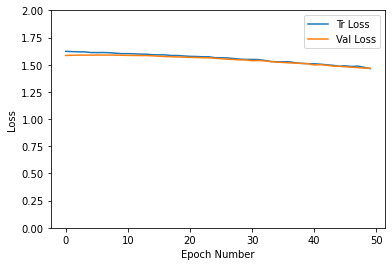

In [18]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,2)
plt.savefig(dataset+'/cnn0.2_loss_curve.png')
plt.show()


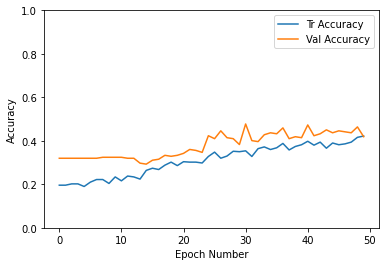

In [19]:
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig(dataset+'/cnn0.2_accuracy_curve.png')
plt.show()

In [20]:
 def computeTestSetAccuracy(model, loss_criterion):
    '''
    Function to compute the accuracy on the test set
    Parameters
        :param model: Model to test
        :param loss_criterion: Loss Criterion to minimize
    '''

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    test_acc = 0.0
    test_loss = 0.0

    # Validation - No gradient tracking needed
    with torch.no_grad():

        # Set to evaluation mode
        model.eval()

        # Validation loop
        for j, (inputs, labels) in enumerate(test_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            test_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to valid_acc
            test_acc += acc.item() * inputs.size(0)

            print("Test Batch number: {:03d}, Test: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

    # Find average test loss and test accuracy
    avg_test_loss = test_loss/test_data_size 
    avg_test_acc = test_acc/test_data_size

    print("Test accuracy : " + str(avg_test_acc))


In [21]:
def predict(model, test_image_name):
    '''
    Function to predict the class of a single test image
    Parameters
        :param model: Model to test
        :param test_image_name: Test image

    '''
    
    transform = image_transforms['test']

    test_image = Image.open(test_image_name)
    plt.imshow(test_image)
    
    test_image_tensor = transform(test_image)

    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 32, 32).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 32, 32)
        
    
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(3, dim=1)
        for i in range(3):
            print("Prediction", i+1, ":", idx_to_class[topclass.cpu().numpy()[0][i]], ", Score: ", topk.cpu().numpy()[0][i])




Prediction 1 : horse , Score:  1.2956984
Prediction 2 : camel , Score:  1.032584
Prediction 3 : cow , Score:  0.9508242


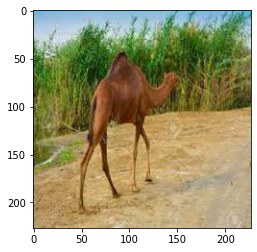

In [42]:
# Test a particular model on a test image

dataset = '/content/drive/My Drive/machine vision/animal_dataset3/validation/'
model = torch.load('/content/drive/My Drive/machine vision/animal_dataset3_model_49.pt')
predict(model, dataset+'camel/download (6).jpg')           

In [43]:
# Load Data from folders
computeTestSetAccuracy(model, loss_func)

Test Batch number: 000, Test: Loss: 1.4293, Accuracy: 0.4688
Test Batch number: 001, Test: Loss: 1.4611, Accuracy: 0.4375
Test Batch number: 002, Test: Loss: 1.3891, Accuracy: 0.5312
Test Batch number: 003, Test: Loss: 1.4622, Accuracy: 0.3125
Test Batch number: 004, Test: Loss: 1.5439, Accuracy: 0.3438
Test Batch number: 005, Test: Loss: 1.5369, Accuracy: 0.4688
Test Batch number: 006, Test: Loss: 1.4525, Accuracy: 0.3667
Test accuracy : 0.4189189199928765
